In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import time

In [141]:
# data = pd.read_excel("C:/Users/Оксана/Desktop/диплом/workbitch.xlsx")
data = pd.read_csv('C:/Users/Оксана/Desktop/диплом/budg.csv')
data = data.drop(columns = ['Unnamed: 0'])

In [3]:
dist = pd.read_excel("C:/Users/Оксана/Desktop/диплом/distances.xlsx")
dist = dist.drop(columns = ['Unnamed: 0'])

In [4]:
# normalizing distances
def normalize(x):
    return (x - x.min())/(x.max() - x.min())
dist = dist.apply(normalize)

In [5]:
cities = pd.read_excel("C:/Users/Оксана/Desktop/диплом/cities.xlsx")

In [142]:
data = data.rename(columns={"вуз": "uni", "УГН": "fac", "ЕГЭ": "score", "направление" : "edp"})

In [143]:
data = data.dropna(subset = ['fac_id'])

In [8]:
uni_data = pd.read_csv("C:/Users/Оксана/Desktop/диплом/restored+pop.csv")
uni_data = uni_data.merge(cities[["city", "reg_id"]], on = "city", how = "left")
uni_data["reg_id"] = uni_data["reg_id"].fillna(105)

In [9]:
uni_data["reg_id"] = uni_data["reg_id"].astype("int")

# Gale-Shapley

In [10]:
def GS(student_preferences, school_preferences, school_capacities, real, n_allowed = 20, n_rounds = 1000, feasible = None, verbose = False):
    """
    
    student_preferences: dict of kind {'stud': ['sch1', 'sch2']}
    school_preferences: dict of kind {'sch' : ['stud1', 'stud2']}
    school_capacities: dict of kind {'sch': 2}
    n_rounds: int
    real: dict 
    
    """
    
    # update everything according to allowed number of schools
    # updating school preferences
    real_student_preferences = {}
    for i in student_preferences.keys():
        real_student_preferences[i] = student_preferences[i][:n_allowed]
    rev_list = {}
    for k,v in real_student_preferences.items():
        for x in v:
            rev_list.setdefault(x,[]).append(k)
    # order this list according to original
    for s in rev_list.keys():
        school_preferences[s] = list(filter(lambda x: x in rev_list[s], school_preferences[s]))+list(filter(lambda x: x not in rev_list[s], school_preferences[s]))
    
    
    school_preferences_updated = school_preferences.copy()
    school_capacities_updated = school_capacities.copy()
    matched_students = {}
    matched_schools = {}
    better = []
    count = 0 # обновлять в начале
    n_unmatched = []
    
    
    

    while sum(list(school_capacities_updated.values())) > 0 and count < n_rounds:
        #update count
        count += 1
        # begin
        # send invitations according to your capacity
        match = school_preferences_updated.copy()
        for key in school_preferences_updated.keys():
            match[key] = match[key][:school_capacities_updated[key]]
        # dict of invitations to each student
        proposals = {}
        for k,v in match.items():
            for x in v:
                proposals.setdefault(x,[]).append(k)
        # add temporary matches from matched_students if there is key like that
        for k in proposals.keys():
            if k in matched_students.keys():
                proposals[k] += [matched_students[k]]
        # student chooses the first school among her invitations
        for key in proposals.keys():
            matched_students[key] = list(filter(lambda x: x in proposals[key], student_preferences[key]))[0]
        # dict of matched schools for the moment
        matched_schools = defaultdict(list)
        {matched_schools[v].append(k) for k, v in matched_students.items()}
        matched_schools = dict(matched_schools)

        # update capacities
        school_capacities_updated = school_capacities.copy()
        for k in matched_schools.keys():
            school_capacities_updated[k] = school_capacities_updated[k] - len(matched_schools[k])
    
        # update school preferences
        for k in match.keys():
            school_preferences_updated[k] = list(filter(lambda v: v not in match[k], school_preferences_updated[k]))
            
    
        # count unmatched agents
        unmatched_students = list(filter(lambda x: x not in matched_students.keys(), student_preferences.keys())) # students
    
        # check the progress
        if verbose:
            print("Step", count, ":")
            print("Proposals", proposals)
            print("Matched students atm:", matched_students)
            print("Matching:", matched_schools)
            print("School preferences atm:", school_preferences_updated)
            print("School capacities atm:", school_capacities_updated)
            print("Unassigned students:", unmatched_students)
            print("\n")
            
        # count unmatched agents
        unmatched_students = list(filter(lambda x: x not in matched_students.keys(), student_preferences.keys())) # students
        
        # save the number of unmatched students at each step
        n_unmatched += [len(unmatched_students)]
        
   ###########################################################################################     
        
    if n_allowed < len(school_capacities):    
        # updating accoring to n_allowed
        delete_keys = []
        for i in matched_students.keys():
            if matched_students[i] not in real_student_preferences[i]:
                delete_keys += [i]
        for i in delete_keys:
            matched_students.pop(i, None)
      
    
        # dict of matched schools for the moment
        matched_schools = defaultdict(list)
        {matched_schools[v].append(k) for k, v in matched_students.items()}
        matched_schools = dict(matched_schools)

        # update capacities
        school_capacities_updated = school_capacities.copy()
        for k in matched_schools.keys():
            school_capacities_updated[k] = school_capacities_updated[k] - len(matched_schools[k])
        
        # count unmatched agents
        unmatched_students = list(filter(lambda x: x not in matched_students.keys(), student_preferences.keys())) # students
    
    
    ##########################################################################################
    
    # adjusting to feasible sets of schools
    if feasible != None:
        matched_students_adjusted = matched_students.copy()
        for i in matched_students.keys():
            if matched_students[i] not in student_preferences[i][:feasible[i]]:
                matched_students_adjusted.pop(i, None)
     
        # recounting other stuff
        # dict of matched schools for the moment
        matched_schools_adjusted = defaultdict(list)
        {matched_schools_adjusted[v].append(k) for k, v in matched_students_adjusted.items()}
        matched_schools_adjusted = dict(matched_schools_adjusted)

        # update capacities
        school_capacities_adjusted = school_capacities.copy()
        for k in matched_schools_adjusted.keys():
            school_capacities_adjusted[k] = school_capacities_adjusted[k] - len(matched_schools_adjusted[k])
            
        # count unmatched agents
        unmatched_students_adjusted = list(filter(lambda x: x not in matched_students_adjusted.keys(), student_preferences.keys())) # students
        
    #####################################################################################################
    
    # I need to count people who are better off
    for i in matched_students.keys():
        if student_preferences[i].index(matched_students[i]) < student_preferences[i].index(real[i]):
            better += [i]
        
    
    return matched_schools, count, unmatched_students, school_capacities_updated, matched_students, n_unmatched, matched_schools_adjusted, unmatched_students_adjusted, school_capacities_adjusted, matched_students_adjusted, better 

In [144]:
data['id'] = np.arange(len(data))
data = data.merge(uni_data[["uni", "uni_id", "region", "city"]], on = "uni", how = "left")

In [145]:
data = data.dropna(subset = ['uni_id'])

In [146]:
data = data.dropna(subset = ['score'])

# All in cycle


for 20 rounds

In [16]:
# assignment data
all_results = [[] for i in range(6)]
matching_adjusted = [[] for i in range(6)]

# rounds data
rounds = np.zeros(20)

# better off data
better_off = []

не забудь убрать нежелательные факи из списка, а только потом начинать надо

In [17]:
# убираем нежелательные факи из списка
nottodo = ['fac63', 'fac65', 'fac64', 'fac66', 'fac67']
todo = data['fac_id'].unique()
todo = list(set(todo) - set(nottodo))

In [18]:
for f_id in todo:
    df = data.loc[(data['fac_id'] == f_id) & (data['year'] == 2019)]
    
    
    mean_scores = pd.DataFrame(df.dropna(subset = ['score']).groupby('uni_id')['score'].agg(['mean', 'min']))
    mean_scores = mean_scores.rename(columns = {"mean" : "mean_score", "min" : "pass_score"})
    
    df = df.merge(mean_scores, on = "uni_id", how = "left")
    
    df = df.merge(cities[['city', 'reg_id']], on = "city", how = "left")
    
    df['id'] = df['id'].astype("string")
    df['i'] = "i"
    df['id'] = df['i']+df['id']
    
    df = df.drop(columns = ['i'])
    
    df["reg_id"] = df["reg_id"].astype("int")
    
    # school capacities
    schools = df.groupby('uni_id')['uni_id'].count()
    school_capacities = {}
    for s in schools.index:
        school_capacities[s] = int(schools[s])
        
    # setting a list of real assignments of people
    real_list = df[['id', 'uni_id']].values
    real = {}
    for i in range(len(real_list)):
        real[real_list[i][0]] = real_list[i][1]    
    
        
    # student preferences
    # I need to save the number of feasible 
    student_preferences = {}
    for i in df["id"]:
        student_preferences[i] = []
    feasible = student_preferences.copy()
    for i in student_preferences.keys():
        ir = int(df.loc[df["id"] == i]["reg_id"])
        dd = pd.DataFrame(dist[ir])
        dd['reg_id'] = dd.index
        uu = uni_data[['uni_id', 'reg_id']].loc[uni_data["uni_id"].isin(school_capacities.keys())]
        uu = uu.merge(dd, on = "reg_id", how = "left").merge(mean_scores, on = "uni_id")
        uu['feasible'] = (uu['pass_score'] <=float(df["score"].loc[df["id"] == i]))
        # normalize mean_score as basic utility
        uu['mean_score'] = (uu['mean_score'] - uu['mean_score'].min())/(uu['mean_score'].max() - uu['mean_score'].min())
        # add final assignment
        uu['assignment'] = np.zeros(len(uu))
        uu.loc[uu['uni_id'] == real[i], 'assignment'] = uu['mean_score']
        # calculate weighted sum
        uu['u'] = -0.33*uu[ir] + 0.33*uu['mean_score'] + 0.34*uu['assignment']
        # add info to feasible dict
        feasible[i] = uu['feasible'].sum()
        student_preferences[i] = list(pd.concat([uu.loc[uu['feasible'] == True].sort_values("u", ascending = False),uu.loc[uu['feasible'] == False].sort_values("u", ascending = False)])["uni_id"])
    
    # school preferences
    # они не совсем такие, сначала идут студенты, которые указали их у себя
    # правда у меня они всех указывают
    school_preferences = {}
    students = list(df.sort_values('score', ascending = False)["id"])
    for s in school_capacities.keys():
        school_preferences[s] = students
    
    # running results
    result = GS(student_preferences, school_preferences, school_capacities, real, n_rounds = 20, feasible = feasible)
    
    
    # saving results
    # all
    all_results[0] += result[4].keys()
    all_results[1] += result[4].values()
    all_results[4] += [1]*len(result[4])
    all_results[0] += result[2]
    all_results[1] += ["NaN"]*len(result[2])
    all_results[4] += [0]*len(result[2])
    all_results[2] += [f_id]*(len(result[4])+len(result[2]))
    all_results[3] += [2019]*(len(result[4])+len(result[2]))
    all_results[5] += ["distance"]*(len(result[4])+len(result[2]))
    better_off += result[10]

    # adjusted
    matching_adjusted[0] += result[9].keys()
    matching_adjusted[1] += result[9].values()
    matching_adjusted[4] += [1]*len(result[9])
    matching_adjusted[0] += result[7]
    matching_adjusted[1] += ["NaN"]*len(result[7])
    matching_adjusted[4] += [0]*len(result[7])
    matching_adjusted[2] += [f_id]*(len(result[9])+len(result[7]))
    matching_adjusted[3] += [2019]*(len(result[9])+len(result[7]))
    matching_adjusted[5] += ["distance"]*(len(result[9])+len(result[7]))

    # rounds
    a = result[5]
    if len(a) < 20:
        a += [0]*(20 - len(a))
    rounds += np.array(a)


# results of aggregation

In [19]:
all_results_df = pd.DataFrame(all_results).T
matching_adjusted_df = pd.DataFrame(matching_adjusted).T
all_results_df = all_results_df.rename(columns = {0 : 'id', 1 : 'uni_id', 2 : 'fac_id', 3 : 'year', 4 : 'assigned', 5 : 'type_pref'})
matching_adjusted_df = matching_adjusted_df.rename(columns = {0 : 'id', 1 : 'uni_id', 2 : 'fac_id', 3 : 'year', 4 : 'assigned', 5 : 'type_pref'})


In [21]:
rounds

array([117605.,  97379.,  85476.,  76649.,  69499.,  64015.,  59516.,
        55648.,  52329.,  49488.,  46884.,  44560.,  42605.,  40778.,
        39044.,  37493.,  36039.,  34676.,  33458.,  32209.])

In [174]:
rounds_ege = np.array([191823., 177037., 169204., 163193., 158131., 153680., 149660.,
       145077., 141554., 137339., 134494., 131716., 128996., 126610.,
       124210., 121893., 119783., 117619., 115330., 113800.])
rounds_dist = np.array([208144., 176638., 155935., 139870., 127299., 116906., 108466.,
       101006.,  94478.,  88782.,  83528.,  78911.,  74610.,  70540.,
        67023.,  63711.,  60678.,  57818.,  55238.,  53001.])

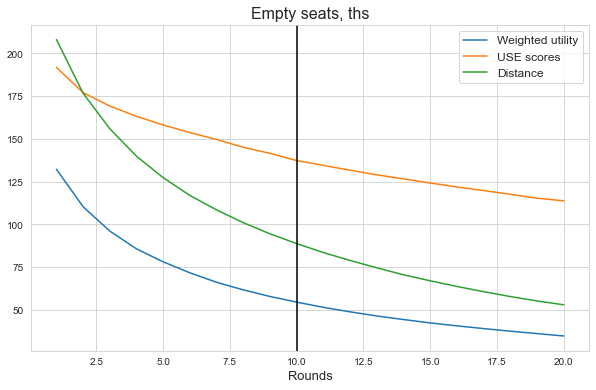

In [186]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(20)+1, rounds/1000, label = 'Weighted utility')

plt.plot(np.arange(20)+1, rounds_ege/1000, label = 'USE scores')
plt.plot(np.arange(20)+1, rounds_dist/1000, label = 'Distance')
plt.legend(prop={'size': 12})
plt.title('Empty seats, ths', fontsize=16)
plt.xlabel('Rounds', fontsize=13)
plt.ylabel('', fontsize=14)
plt.axvline(x=10, color = 'black')
plt.grid(True)
plt.savefig('rounds19.png')

In [22]:
# добавить колонку, которая говорит, лучше тебе или нет
# добавить ее к matching_adjusted мб?
matching_adjusted_df['better'] = np.zeros(matching_adjusted_df.shape[0])
matching_adjusted_df.loc[matching_adjusted_df['id'].isin(better_off), 'better'] = 1

In [23]:
#matching_adjusted_df.to_csv('C:/Users/Оксана/Desktop/диплом/no_weighted19_20.csv')

### Comparative analysis
#### 10 rounds vs. 20 rounds
сравнение с 20: насколько меньше тех, кому стало лучше; что со средними баллами

In [24]:
ma19_20 = matching_adjusted_df
ma19_20['type_pref'] = 'weighted'

In [25]:
ma21_20 = pd.read_csv('C:/Users/Оксана/Desktop/диплом/no_weighted21_20.csv')
ma21_20 = ma21_20.drop('Unnamed: 0', axis = 1)

In [26]:
ma19_10 = pd.read_csv('C:/Users/Оксана/Desktop/диплом/no_weighted19_10.csv')
ma19_10 = ma19_10.drop('Unnamed: 0', axis = 1)

In [27]:
ma21_10 = pd.read_csv('C:/Users/Оксана/Desktop/диплом/no_weighted21_10.csv')
ma21_10 = ma21_10.drop('Unnamed: 0', axis = 1)

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3106: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


1. Сколько нераспределенных?
+ в 2019: 14.25 % vs. 21.9 %
+ в 2021: 13.93 % vs. 21.64 %

2. Кто такие нераспределенные?

In [35]:
data['id'] = data['id'].astype("string")
data['i'] = "i"
data['id'] = data['i']+data['id']
data = data.drop(columns = ['i'])

In [36]:
ma19_20 = ma19_20.merge(data[['id', 'score']], on = 'id')
ma19_10 = ma19_10.merge(data[['id', 'score']], on = 'id')
ma21_20 = ma21_20.merge(data[['id', 'score']], on = 'id')
ma21_10 = ma21_10.merge(data[['id', 'score']], on = 'id')

In [37]:
ma19_20.shape

(225988, 8)

In [38]:
ua19_20 = np.array(ma19_20.loc[ma19_20['assigned'] == 0, 'score'])
ua19_10 = np.array(ma19_10.loc[ma19_10['assigned'] == 0, 'score'])
ua21_20 = np.array(ma21_20.loc[ma21_20['assigned'] == 0, 'score'])
ua21_10 = np.array(ma21_10.loc[ma21_10['assigned'] == 0, 'score'])

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


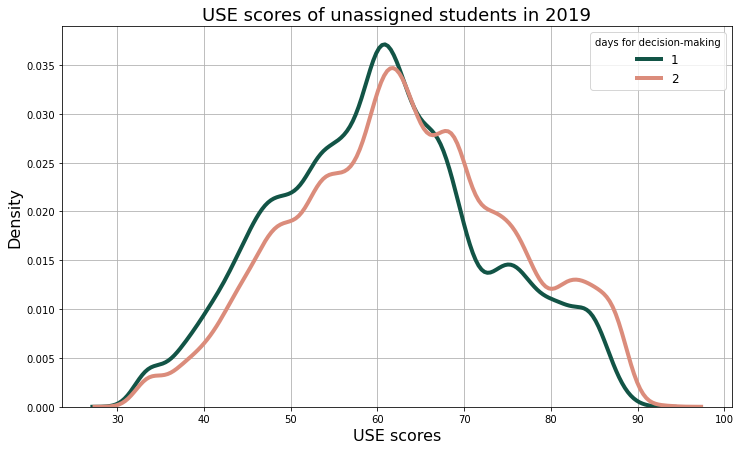

In [40]:
fig, ax = plt.subplots(figsize = (12,7))


pl = sns.distplot(ua19_20, hist=False, kde=True, 
             bins=int(180/5), color = '#125446', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
sns.distplot(ua19_10, hist=False, kde=True, 
             bins=int(180/5), color = '#DB8C7B', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
pl.set_xlabel('USE scores', fontsize = 16)
pl.set_ylabel('Density', fontsize = 16)
pl.set_title('USE scores of unassigned students in 2019', fontsize = 18)
pl.legend(labels = ['1', '2'], title = 'days for decision-making', fontsize = 'large')
plt.grid(True) 
plt.savefig('no_ua19_1020.png')

In [41]:
scipy.stats.ttest_ind(ua19_20, ua19_10)

Ttest_indResult(statistic=-29.071268527037702, pvalue=7.30069456283691e-185)

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


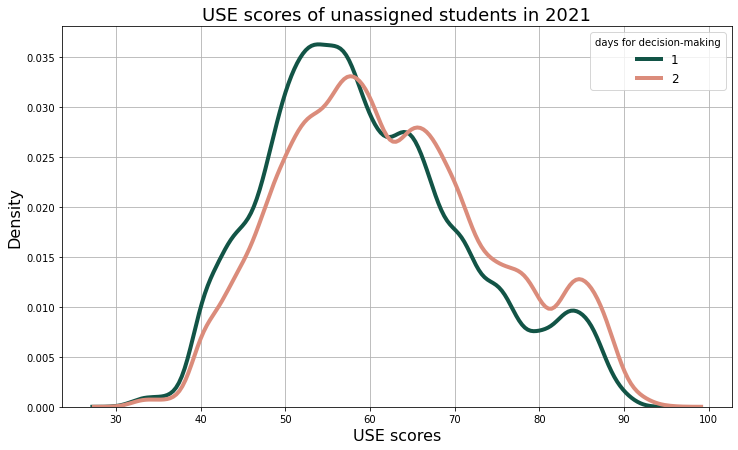

In [42]:
fig, ax = plt.subplots(figsize = (12,7))


pl = sns.distplot(ua21_20, hist=False, kde=True, 
             bins=int(180/5), color = '#125446', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
sns.distplot(ua21_10, hist=False, kde=True, 
             bins=int(180/5), color = '#DB8C7B', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
pl.set_xlabel('USE scores', fontsize = 16)
pl.set_ylabel('Density', fontsize = 16)
pl.set_title('USE scores of unassigned students in 2021', fontsize = 18)
pl.legend(labels = ['1', '2'], title = 'days for decision-making', fontsize = 'large')
plt.grid(True) 
plt.savefig('no_ua21_1020.png')

In [43]:
scipy.stats.ttest_ind(ua21_20, ua21_10)

Ttest_indResult(statistic=-32.81439546636657, pvalue=7.914957172158434e-235)

3. Как изменились баллы в вузах Forbes?

In [201]:
notforbes19_10.mean(), notforbes21_10.mean()

(68.2737717458359, 68.65042216823352)

In [202]:
variance(notforbes19_10), variance(notforbes21_10)

(141.1377239867566, 152.0112435367385)

In [44]:
ma19_20 = ma19_20.merge(uni_data[['uni_id', 'forbes']], on = 'uni_id', how = 'left')
ma19_10 = ma19_10.merge(uni_data[['uni_id', 'forbes']], on = 'uni_id', how = 'left')
ma21_20 = ma21_20.merge(uni_data[['uni_id', 'forbes']], on = 'uni_id', how = 'left')
ma21_10 = ma21_10.merge(uni_data[['uni_id', 'forbes']], on = 'uni_id', how = 'left')

In [46]:
forbes19_20 = np.array(ma19_20.loc[(ma19_20['assigned'] == 1) & (ma19_20['forbes'] == 2), 'score'])
forbes19_10 = np.array(ma19_10.loc[(ma19_10['assigned'] == 1) & (ma19_10['forbes'] == 2), 'score'])
forbes21_20 = np.array(ma21_20.loc[(ma21_20['assigned'] == 1) & (ma21_20['forbes'] == 2), 'score'])
forbes21_10 = np.array(ma21_10.loc[(ma21_10['assigned'] == 1) & (ma21_10['forbes'] == 2), 'score'])

In [47]:
data = data.merge(uni_data[['uni_id', 'forbes']], on = 'uni_id')

In [48]:
forbes_real19 = np.array(data.loc[(data['year'] == 2019) & (data['forbes'] == 2), 'score'])
forbes_real21 = np.array(data.loc[(data['year'] == 2021) & (data['forbes'] == 2), 'score'])

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for ker

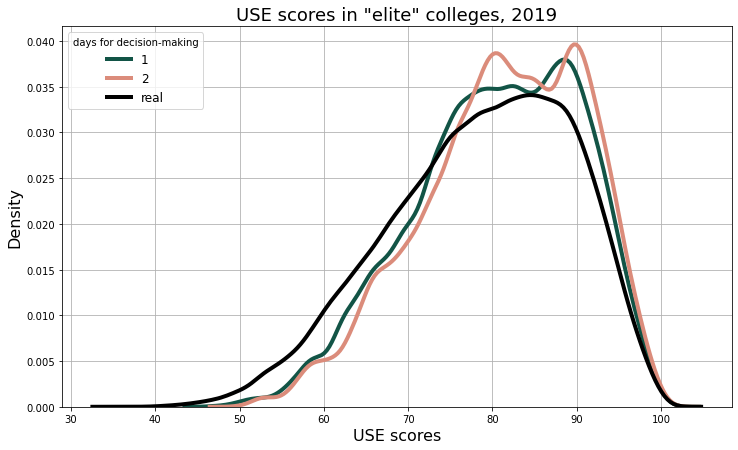

In [49]:
fig, ax = plt.subplots(figsize = (12,7))


pl = sns.distplot(forbes19_20, hist=False, kde=True, 
             bins=int(180/5), color = '#125446', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
sns.distplot(forbes19_10, hist=False, kde=True, 
             bins=int(180/5), color = '#DB8C7B', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
sns.distplot(forbes_real19, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
pl.set_xlabel('USE scores', fontsize = 16)
pl.set_ylabel('Density', fontsize = 16)
pl.set_title('USE scores in "elite" colleges, 2019', fontsize = 18)
pl.legend(labels = ['1', '2', 'real'], title = 'days for decision-making', fontsize = 'large')
plt.grid(True) 
plt.savefig('no_forbes19_1020.png')

In [96]:
scipy.stats.ttest_ind(forbes19_10, forbes19_20)

Ttest_indResult(statistic=13.823362535236106, pvalue=1.961385844117428e-43)

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for ker

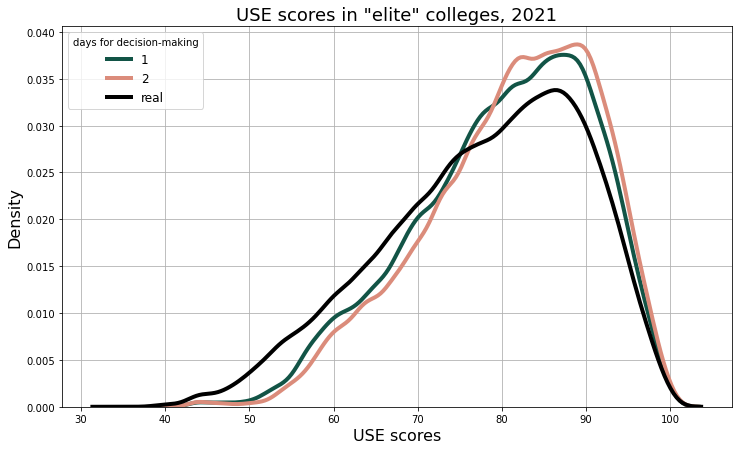

In [59]:
fig, ax = plt.subplots(figsize = (12,7))


pl = sns.distplot(forbes21_20, hist=False, kde=True, 
             bins=int(180/5), color = '#125446', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
sns.distplot(forbes21_10, hist=False, kde=True, 
             bins=int(180/5), color = '#DB8C7B', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
sns.distplot(forbes_real21, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
pl.set_xlabel('USE scores', fontsize = 16)
pl.set_ylabel('Density', fontsize = 16)
pl.set_title('USE scores in "elite" colleges, 2021', fontsize = 18)
pl.legend(labels = ['1', '2', 'real'], title = 'days for decision-making', fontsize = 'large')
plt.grid(True) 
plt.savefig('no_forbes21_1020.png')

In [60]:
scipy.stats.ttest_ind(forbes21_20, forbes_real21, equal_var = False)

Ttest_indResult(statistic=41.314607182140705, pvalue=0.0)

4. Как изменились баллы в других вузах?

In [61]:
notforbes19_20 = np.array(ma19_20.loc[(ma19_20['assigned'] == 1) & (ma19_20['forbes'] != 2), 'score'])
notforbes19_10 = np.array(ma19_10.loc[(ma19_10['assigned'] == 1) & (ma19_10['forbes'] != 2), 'score'])
notforbes21_20 = np.array(ma21_20.loc[(ma21_20['assigned'] == 1) & (ma21_20['forbes'] != 2), 'score'])
notforbes21_10 = np.array(ma21_10.loc[(ma21_10['assigned'] == 1) & (ma21_10['forbes'] != 2), 'score'])

In [62]:
notforbes_real19 = np.array(data.loc[(data['year'] == 2019) & (data['forbes'] != 2), 'score'])
notforbes_real21 = np.array(data.loc[(data['year'] == 2021) & (data['forbes'] != 2), 'score'])

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for ker

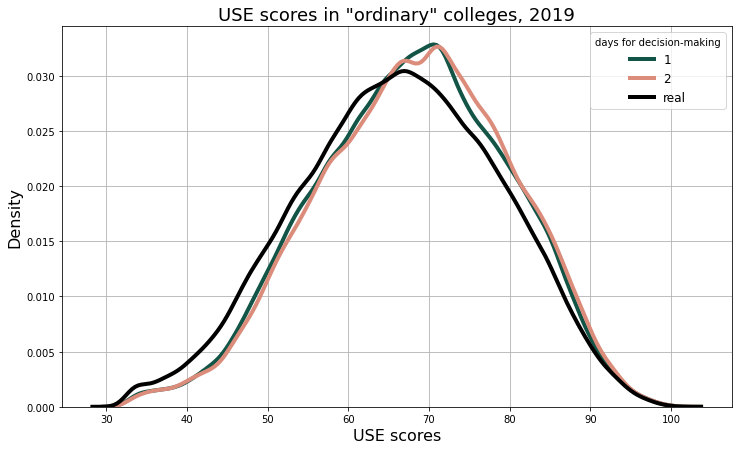

In [63]:
fig, ax = plt.subplots(figsize = (12,7))


pl = sns.distplot(notforbes19_20, hist=False, kde=True, 
             bins=int(180/5), color = '#125446', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
sns.distplot(notforbes19_10, hist=False, kde=True, 
             bins=int(180/5), color = '#DB8C7B', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
sns.distplot(notforbes_real19, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
pl.set_xlabel('USE scores', fontsize = 16)
pl.set_ylabel('Density', fontsize = 16)
pl.set_title('USE scores in "ordinary" colleges, 2019', fontsize = 18)
pl.legend(labels = ['1', '2', 'real'], title = 'days for decision-making', fontsize = 'large')
plt.grid(True) 
plt.savefig('no_notforbes19_1020.png')

In [65]:
scipy.stats.ttest_ind(notforbes_real19, notforbes19_20)

Ttest_indResult(statistic=-35.781788325978575, pvalue=9.052413316049476e-280)

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for ker

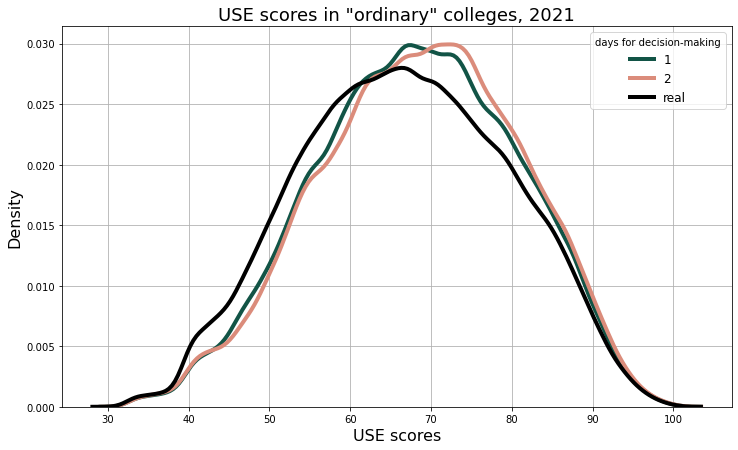

In [66]:
fig, ax = plt.subplots(figsize = (12,7))


pl = sns.distplot(notforbes21_20, hist=False, kde=True, 
             bins=int(180/5), color = '#125446', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
sns.distplot(notforbes21_10, hist=False, kde=True, 
             bins=int(180/5), color = '#DB8C7B', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
sns.distplot(notforbes_real21, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
pl.set_xlabel('USE scores', fontsize = 16)
pl.set_ylabel('Density', fontsize = 16)
pl.set_title('USE scores in "ordinary" colleges, 2021', fontsize = 18)
pl.legend(labels = ['1', '2', 'real'], title = 'days for decision-making', fontsize = 'large')
plt.grid(True) 
plt.savefig('no_notforbes21_1020.png')

GS vs.real

forbes

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


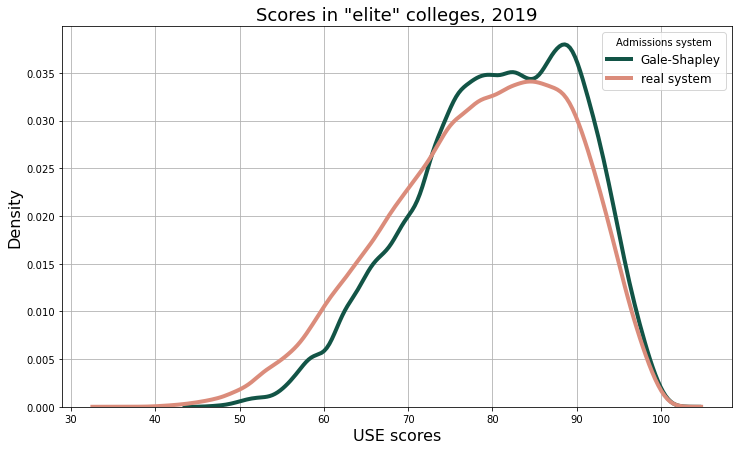

In [97]:
fig, ax = plt.subplots(figsize = (12,7))


pl = sns.distplot(forbes19_20, hist=False, kde=True, 
             bins=int(180/5), color = '#125446', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
sns.distplot(forbes_real19, hist=False, kde=True, 
             bins=int(180/5), color = '#DB8C7B', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
pl.set_xlabel('USE scores', fontsize = 16)
pl.set_ylabel('Density', fontsize = 16)
pl.set_title('Scores in "elite" colleges, 2019', fontsize = 18)
pl.legend(labels = ['Gale-Shapley', 'real system'], title = 'Admissions system', fontsize = 'large')
plt.grid(True) 
plt.savefig('no_forbes19.png')

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


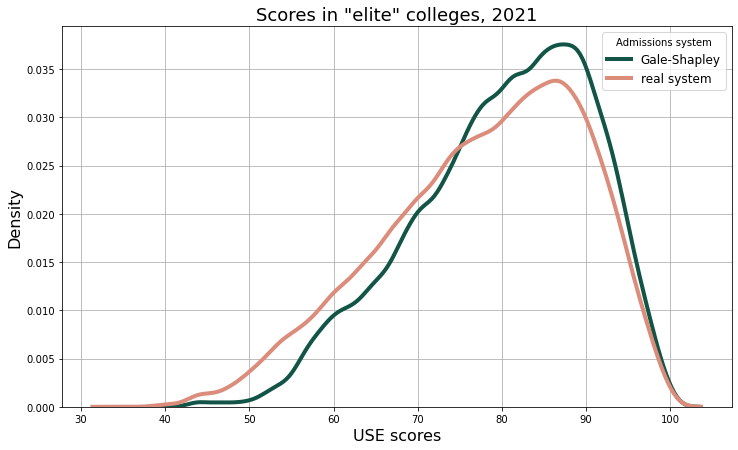

In [98]:
fig, ax = plt.subplots(figsize = (12,7))


pl = sns.distplot(forbes21_20, hist=False, kde=True, 
             bins=int(180/5), color = '#125446', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
sns.distplot(forbes_real21, hist=False, kde=True, 
             bins=int(180/5), color = '#DB8C7B', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
pl.set_xlabel('USE scores', fontsize = 16)
pl.set_ylabel('Density', fontsize = 16)
pl.set_title('Scores in "elite" colleges, 2021', fontsize = 18)
pl.legend(labels = ['Gale-Shapley', 'real system'], title = 'Admissions system', fontsize = 'large')
plt.grid(True) 
plt.savefig('no_forbes21.png')

In [302]:
pd.DataFrame(ma19_20.loc[ma19_20['forbes'] == 2].groupby('city')['city'].agg('count')).rename(columns = {'city' : 'n'}).reset_index().sort_values('n', ascending = False)['n'].sum()

78388

In [303]:
(32121 + 11345)/78388


0.554498137470021

ordinary

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


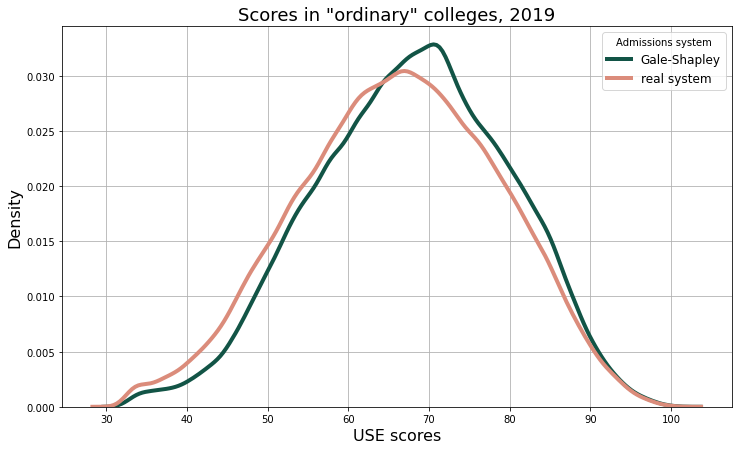

In [99]:
fig, ax = plt.subplots(figsize = (12,7))


pl = sns.distplot(notforbes19_20, hist=False, kde=True, 
             bins=int(180/5), color = '#125446', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
sns.distplot(notforbes_real19, hist=False, kde=True, 
             bins=int(180/5), color = '#DB8C7B', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
pl.set_xlabel('USE scores', fontsize = 16)
pl.set_ylabel('Density', fontsize = 16)
pl.set_title('Scores in "ordinary" colleges, 2019', fontsize = 18)
pl.legend(labels = ['Gale-Shapley', 'real system'], title = 'Admissions system', fontsize = 'large')
plt.grid(True) 
plt.savefig('no_notforbes19.png')

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


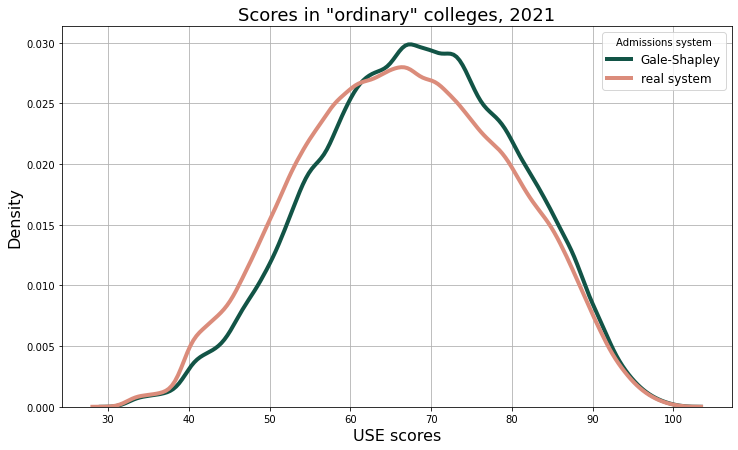

In [100]:
fig, ax = plt.subplots(figsize = (12,7))


pl = sns.distplot(notforbes21_20, hist=False, kde=True, 
             bins=int(180/5), color = '#125446', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
sns.distplot(notforbes_real21, hist=False, kde=True, 
             bins=int(180/5), color = '#DB8C7B', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                 ax = ax)
pl.set_xlabel('USE scores', fontsize = 16)
pl.set_ylabel('Density', fontsize = 16)
pl.set_title('Scores in "ordinary" colleges, 2021', fontsize = 18)
pl.legend(labels = ['Gale-Shapley', 'real system'], title = 'Admissions system', fontsize = 'large')
plt.grid(True) 
plt.savefig('no_notforbes21.png')

In [114]:
rounds

array([117605.,  97379.,  85476.,  76649.,  69499.,  64015.,  59516.,
        55648.,  52329.,  49488.,  46884.,  44560.,  42605.,  40778.,
        39044.,  37493.,  36039.,  34676.,  33458.,  32209.])

In [166]:
variance(ma21_20.loc[ma21_20['forbes'] != 2]['score'])

160.31215542862105

In [148]:
data = data.merge(uni_data[['uni_id', 'forbes']], on = "uni_id")

In [169]:
(ma21_20['assigned'] == 0).sum()/ma21_20.shape[0]

0.1392622410224921

In [162]:
data.loc[(data['year'] == 2021) & (data['forbes'] != 2)]['score'].mean()

66.60094407969123